## Magdalena's Github Programming Language-Prediction Project

03 March 2023

In [1]:
#imports

import pandas as pd
import requests
import numpy as np
import os

import acquire as a
import prepare as p
import explore_functions as e

from bs4 import BeautifulSoup
import time

import env
from env import github_token, github_username

import re
import unicodedata
import nltk
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [2]:
headers = {"Authorization": f"token {env.github_token}", "User-Agent":{env.github_username}}


In [3]:
# url = 'https://github.com/search?o=desc&q=shoes&s=stars&type=Repositories'
# response = requests.get(url)

# # we get back html as the response

In [4]:
# soup = BeautifulSoup(response.content, 'html.parser')
# 

In [5]:
# list_o_elements = soup.find_all('a')

In [6]:
# # for loop to get githug urls

# pageCount = 15
# urlsList = []

# base = 'https://github.com/search?o=desc&p={}&q=shoes&s=stars&type=Repositories' #curly braces let you format

# for x in range(pageCount)[0:]:
#     urlsList.append(base.format(x))

In [7]:
# urlsList

In [8]:
# function no longer needed

# def scrape_one_page(topic):
#     '''
#     This function will, given a topic on the 'inshorts' news website, scrape the first page of articles within that category and put that data into a json file.
#     '''
#     base_url = 'https://inshorts.com/en/read/'
    
#     response = get(base_url + topic)
    
#     soup = BeautifulSoup(response.content, 'html.parser')
    
#     titles = soup.find_all('span', itemprop='headline')
    
#     summaries = soup.find_all('div', itemprop='articleBody')
    
#     summary_list = []
    
#     for i in range(len(titles)):
        
#         temp_dict = {'category': topic,
#                      'title': titles[i].text,
#                      'content': summaries[i].text}
        
#         summary_list.append(temp_dict)
        
#     return summary_list

In [9]:
# list200 = []

# for i in urlsList:
#     response = requests.get(i)
#     time.sleep(15)
#     list200.append(response)

In [10]:
# unnecesary, but working, function

# for url in urlsList:
#     time.sleep(1)
    
#     def github_api_request(url: str):
        
#         response = requests.get(url, headers = a.headers)
#         response_data = response.json()
        
#         if response.status_code != 200:
#             raise Exception(
#                 f"Error response from github api! status code: {response.status_code}, "
#                 f"response: {json.dumps(response_data)}")
#             x
#         return response_data


In [11]:
# github_api_request(urlsList)

### Below : new get repos funtion to obtain more  links.
### dumped to repos.py 
### no need to run a second time

In [12]:
# # function to get all the repos that mention 'shoes' from github
# a.get_repo_links_200(github_token = github_token, github_username = github_username,
                          #                 topic = 'shoes', number_of_pages = 20)

In [13]:
# function to obtain scraped github data ('repos.py' file obtained via 'a.get_repo_links_200')

# sth = a.scrape_github_data()

In [14]:
# uploading json file of 'shoes' repos

sth = pd.read_json('repos.json')

In [15]:
# make dataframe of dictionary of readmes

df = pd.DataFrame(sth)

In [16]:
txt = "My name is Ståle+++"

print(txt.encode(encoding="ascii",errors="backslashreplace"))
print(txt.encode(encoding="ascii",errors="ignore"))
print(txt.encode(encoding="ascii",errors="namereplace"))
print(txt.encode(encoding="ascii",errors="replace"))
print(txt.encode(encoding="ascii",errors="xmlcharrefreplace"))

b'My name is St\\xe5le+++'
b'My name is Stle+++'
b'My name is St\\N{LATIN SMALL LETTER A WITH RING ABOVE}le+++'
b'My name is St?le+++'
b'My name is St&#229;le+++'


In [17]:
def clean_text(text, extra_stopwords=['r', 'u', '2', 'ltgt']):
    '''
    This function does what 'basic_clean' does, but takes it a step further by removing stopwords and lemmatizing the text.
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    
    stopwords = nltk.corpus.stopwords.words('english') + extra_stopwords
    
    clean_text = (unicodedata.normalize('NFKD', text)
                   .encode('ascii', 'ignore')
                   .decode('utf-8', 'ignore')
                   .lower())
    
    words = re.sub(r'[^\w\s+]', '', clean_text).split()
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [18]:
# # testing function 

# clean_text('afdkj be an +++ c c+ c++ ruby java rust julia r python')

In [19]:
# def stem(string):
#     '''
#     This function takes in text and returns the stem word joined back into the text
#     '''
#     #create porter stemmer
#     ps = nltk.porter.PorterStemmer()
    
#     #use the stem, split string using each word
#     stems = [ps.stem(word) for word in string.split()]
    
#     #join stem word to string
#     string = ' '.join(stems)

#     return string


In [20]:
# # testing out 'stem' function

# stem('afdkj be an +++ c c+ c++ ruby java rust julia r python')

In [21]:
def lemmatize(string):
    '''
    This function takes in a string and returns the lemmatized word joined back into the string
    '''
    #create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    #look at the article 
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    
    #join lemmatized words into article
    string = ' '.join(lemmas)

    return string


In [22]:
# # testing out 'lemmatize' function

# lemmatize('afdkj be an +++ c c+ c++ ruby java rust julia r python')

In [23]:
# Sm's 

def prep_article_data(df, column, exclude_words=[]):

    df['clean'] = df[column].apply(p.basic_clean)\
                            .apply(p.tokenize)\
                            .apply(p.remove_stopwords,
                                  exclude_words=exclude_words)
    
    df['stemmed'] = df['clean'].apply(p.stem)
    
    df['lemmatized'] = df['clean'].apply(p.lemmatize)
    
    return df[['repo', column, 'clean', 'stemmed', 'lemmatized']]

In [24]:
prep_article_data(df, 'readme_contents', exclude_words = ['slammer'])

,repo,readme_contents,clean,stemmed,lemmatized
0,justinmk/vim-sneak,sneak.vim 👟\n================\n\nJump to any l...,sneakvim jump location specified two character...,sneakvim jump locat specifi two charact sneak ...,sneakvim jump location specified two character...
1,google-research-datasets/Objectron,"\n<div align=""center"">\n\n# Objectron Dataset\...",div aligncenter objectron dataset objectron da...,div aligncent objectron dataset objectron data...,div aligncenter objectron dataset objectron da...
2,shoes/shoes4,# Shoes 4 [![Linux Build Status](https://secur...,shoes 4 linux build statushttpssecuretraviscio...,shoe 4 linux build statushttpssecuretraviscior...,shoe 4 linux build statushttpssecuretraviscior...
3,shoes/shoes-deprecated,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...,repo longer active looking continuing shoes 3 ...,repo longer activ look continu shoe 3 support ...,repo longer active looking continuing shoe 3 s...
4,filamentgroup/shoestring,:warning: This project is archived and the rep...,warning project archived repository longer mai...,warn project archiv repositori longer maintain...,warning project archived repository longer mai...
...,...,...,...,...,...
193,alexyoung/snake-shoes,h2. Snake in Shoes\n\nThis is a simple Snake g...,h2 snake shoes simple snake game written ruby ...,h2 snake shoe simpl snake game written rubi sh...,h2 snake shoe simple snake game written ruby s...
194,kaushiksheel/ShoesStore-Frontend-Typescript,# Shoe Store Ecommerce Application\n\n## Intro...,shoe store ecommerce application introduction ...,shoe store ecommerc applic introduct ecommerc ...,shoe store ecommerce application introduction ...
195,devyn/shoes-web,== Welcome to Radiant\n\nRadiant is a no-fluff...,welcome radiant radiant nofluff open source co...,welcom radiant radiant nofluff open sourc cont...,welcome radiant radiant nofluff open source co...
196,mjokic/adidas_carter,# adidas_carter\n\nAdidas carter helps you car...,adidas_carter adidas carter helps cart shoes a...,adidas_cart adida carter help cart shoe adida ...,adidas_carter adidas carter help cart shoe adi...


In [25]:
# applying 'clean_text' function to 'readme_contents' col of df
# 
df['cleaned_text'] = df['readme_contents'].apply(clean_text)

In [26]:
df.head(2)

,repo,language,readme_contents,clean,stemmed,lemmatized,cleaned_text
0,justinmk/vim-sneak,Vim Script,sneak.vim 👟\n================\n\nJump to any l...,sneakvim jump location specified two character...,sneakvim jump locat specifi two charact sneak ...,sneakvim jump location specified two character...,"[sneakvim, jump, location, specified, two, cha..."
1,google-research-datasets/Objectron,Jupyter Notebook,"\n<div align=""center"">\n\n# Objectron Dataset\...",div aligncenter objectron dataset objectron da...,div aligncent objectron dataset objectron data...,div aligncenter objectron dataset objectron da...,"[div, aligncenter, objectron, dataset, objectr..."


In [27]:
df['clean']

0      sneakvim jump location specified two character...
1      div aligncenter objectron dataset objectron da...
2      shoes 4 linux build statushttpssecuretraviscio...
3      repo longer active looking continuing shoes 3 ...
4      warning project archived repository longer mai...
                             ...                        
193    h2 snake shoes simple snake game written ruby ...
194    shoe store ecommerce application introduction ...
195    welcome radiant radiant nofluff open source co...
196    adidas_carter adidas carter helps cart shoes a...
197    shoes shoes website variouse devicesreadmetest...
Name: clean, Length: 198, dtype: object

In [28]:
#returning all the words in readme_contents individually

readme_words = clean_text(' '.join(df['readme_contents']))

In [29]:

# setting the cleaned txt to Series and counting word frequency
count = pd.Series(readme_words).value_counts()
count

barry                                                                                                                                     751
shoe                                                                                                                                      651
master                                                                                                                                    494
mind                                                                                                                                      486
bee                                                                                                                                       367
                                                                                                                                         ... 
00519                                                                                                                                       1
sample

In [30]:
df.isna().sum()

repo                0
language           13
readme_contents     0
clean               0
stemmed             0
lemmatized          0
cleaned_text        0
dtype: int64

In [31]:
df = df.dropna()

In [32]:
#returning all the words in language individually

lang_words = clean_text(' '.join(df['language']))


In [33]:

# setting the cleaned txt to Series and counting word frequency
count = pd.Series(lang_words).value_counts()
count

javascript      42
ruby            41
python          26
dart            17
html            13
jupyter          6
notebook         6
typescript       6
c                5
java             4
cs               3
swift            3
viml             2
c++              2
vim              2
script           2
kotlin           2
shell            1
rust             1
php              1
tex              1
lua              1
go               1
emacs            1
lisp             1
handlebar        1
vue              1
sc               1
coffeescript     1
dtype: int64

In [34]:
def lesser_langs_list(df):
    
    '''
    this function takes in the dataframe of scraped
    github data, cleans, lemmatises & removes stopwords,
    isolates the language column into word counts, then
    turns that col into a separate DF, isolates out the 
    top 6 languages, and turns all the remaining languages
    into a list
    '''
    
    #returning all the words in language individually
    lang_words = clean_text(' '.join(df['language']))

    # setting the cleaned txt to Series and counting word frequency
    count = pd.Series(lang_words).value_counts()

    # amke into df
    lang_df = pd.DataFrame(count)

    # language counts, resetting & renaming index
    lang_df.columns = ['counts']
    lang_df = lang_df.reset_index()
    lang_df = lang_df.rename(columns = {'index':'language'})

    # all the languages that are not in the top 6
    langs = ['javascript', 'html', 'ruby', 'python', 'dart']
    other_langs = lang_df[~lang_df['language'].isin(langs)]

    # dropping 'counts col'
    other_langs = other_langs.drop(columns=['counts'])
    
    # turning df into a list
    other_langs = other_langs.values.tolist()
    
    return other_langs

In [35]:
# the languages in 'language' col

df['language'].value_counts()

JavaScript          42
Ruby                41
Python              26
Dart                17
HTML                13
TypeScript           6
Jupyter Notebook     6
Java                 4
C#                   3
Swift                3
CSS                  3
C                    2
C++                  2
Kotlin               2
VimL                 2
Handlebars           1
Vue                  1
Go                   1
SCSS                 1
Emacs Lisp           1
Vim Script           1
Lua                  1
TeX                  1
Rust                 1
Shell                1
PHP                  1
Vim script           1
CoffeeScript         1
Name: language, dtype: int64

In [36]:
# amke into df

lang_df = pd.DataFrame(count)
lang_df.head()

,0
javascript,42
ruby,41
python,26
dart,17
html,13


In [37]:
# language counts, resetting & renaming index

lang_df.columns = ['counts']
lang_df = lang_df.reset_index()
lang_df

,index,counts
0,javascript,42
1,ruby,41
2,python,26
3,dart,17
4,html,13
5,jupyter,6
6,notebook,6
7,typescript,6
8,c,5
9,java,4


In [38]:
lang_df = lang_df.rename(columns = {'index':'language'})


In [39]:
# all the languages that are not in the top 5

langs = ['javascript', 'ruby', 'python', 'dart','html']

other_langs = lang_df[~lang_df['language'].isin(langs)]
other_langs

,language,counts
5,jupyter,6
6,notebook,6
7,typescript,6
8,c,5
9,java,4
10,cs,3
11,swift,3
12,viml,2
13,c++,2
14,vim,2


In [40]:
other_langs = other_langs.drop(columns = ['counts'])

In [41]:
other_langs = other_langs.values.tolist()
other_langs

[['jupyter'],
 ['notebook'],
 ['typescript'],
 ['c'],
 ['java'],
 ['cs'],
 ['swift'],
 ['viml'],
 ['c++'],
 ['vim'],
 ['script'],
 ['kotlin'],
 ['shell'],
 ['rust'],
 ['php'],
 ['tex'],
 ['lua'],
 ['go'],
 ['emacs'],
 ['lisp'],
 ['handlebar'],
 ['vue'],
 ['sc'],
 ['coffeescript']]

In [42]:
list_of_other = other_langs
list_of_other

[['jupyter'],
 ['notebook'],
 ['typescript'],
 ['c'],
 ['java'],
 ['cs'],
 ['swift'],
 ['viml'],
 ['c++'],
 ['vim'],
 ['script'],
 ['kotlin'],
 ['shell'],
 ['rust'],
 ['php'],
 ['tex'],
 ['lua'],
 ['go'],
 ['emacs'],
 ['lisp'],
 ['handlebar'],
 ['vue'],
 ['sc'],
 ['coffeescript']]

In [43]:
# df of frequency counts for all the languages

list_of_other = ['TypeScript', 'Jupyter Notebook', 'Java', 'C#', 'Swift', 'CSS', 'C', 'C++', 'Kotlin',
         'VimL', 'Handlebars', 'Vue', 'Go', 'SCSS', 'Emacs Lisp', 'Vim Script', 'Lua', 'TeX',
         'Rust', 'Shell', 'PHP', 'Vim script', 'CoffeeScript']

for i in list_of_other:
    df['language'] = df['language'].replace(i, 'Other')


In [44]:
top_freq = df['language'].value_counts()
top_freq

Other         46
JavaScript    42
Ruby          41
Python        26
Dart          17
HTML          13
Name: language, dtype: int64

In [110]:
# most frequent words, label-coloured

def lang_freq_barchart():
    
    '''
    this function uses the top frequency programming
    languages and plots the top 5 languages along 
    with the language category 'other'.
    '''
    
    # assign variable
    graphed = top_freq.plot.bar(figsize = (9,6), color = 'magenta')

    plt.title('Github shoe repository programming language word counts')

    # set xtick labels and properties
    plt.xticks([0, 1, 2, 3, 4, 5], 
               [ 'Other', 'JavaScript', 'Ruby', 'Python', 'Dart', 'HTML'],
                rotation = 25)

    plt.legend([],[])
    plt.yticks(np.arange(0, 49, 6))
    
    # display y axis grids
    graphed.yaxis.grid(True)

    plt.ylabel('Count')
    plt.xlabel('Repository language frequency')

    plt.show()

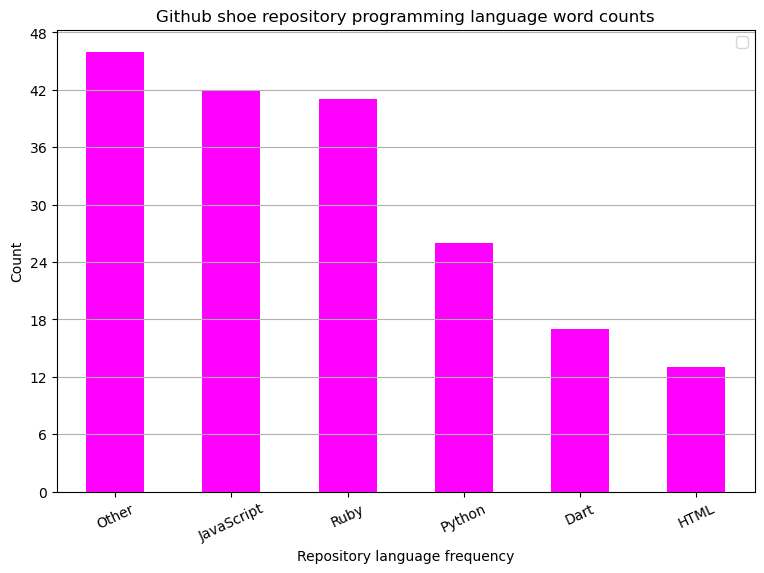

In [111]:
lang_freq_barchart()

In [47]:
df['language']

0           Other
1           Other
2            Ruby
3           Other
4      JavaScript
          ...    
191          Dart
194         Other
195    JavaScript
196         Other
197          HTML
Name: language, Length: 185, dtype: object

In [48]:
# individual readme words from each language type

javascript_words = clean_text(' '.join(df[df['language'] == 'JavaScript']['readme_contents']))
                              
html_words = clean_text(' '.join(df[df['language'] == 'HTML']['readme_contents'])) 

dart_words = p.clean_text(' '.join(df[df['language'] == 'Dart']['readme_contents'])) 

ruby_words = clean_text(' '.join(df[df['language'] == 'Ruby']['readme_contents'])) 

python_words = clean_text(' '.join(df[df['language'] == 'Python']['readme_contents'])) 

other_words = clean_text(' '.join(df[df['language'] == 'Other']['readme_contents']))

# readme_words = [javascript_words, html_words, css_words, ruby_words, python_words, typescript_words, other_words]
# 


dart_words

['adidas',
 'shoe',
 'ecommerce',
 'app',
 'ui',
 'assetspreviewjpg',
 'getting',
 'started',
 'project',
 'starting',
 'point',
 'flutter',
 'application',
 'resource',
 'get',
 'started',
 'first',
 'flutter',
 'project',
 'lab',
 'write',
 'first',
 'flutter',
 'apphttpsflutteriodocsgetstartedcodelab',
 'cookbook',
 'useful',
 'flutter',
 'sampleshttpsflutteriodocscookbook',
 'help',
 'getting',
 'started',
 'flutter',
 'view',
 'online',
 'documentationhttpsflutteriodocs',
 'offer',
 'tutorial',
 'sample',
 'guidance',
 'mobile',
 'development',
 'full',
 'api',
 'reference',
 'flutter',
 'shoe',
 'shop',
 'application',
 'ui',
 'design',
 'animation',
 'part',
 'flutter100daysofcode',
 'let',
 'create',
 'beautiful',
 'animated',
 'shoe',
 'shop',
 'application',
 'ui',
 'flutter',
 'watch',
 'youtubehttpsyoutubelrmcjiypnjg',
 'previous',
 'design',
 'checkout',
 'youtube',
 'channelhttpsyoutubecomafgprogrammer',
 'development',
 'setup',
 'clone',
 'repository',
 'run',
 'followi

In [49]:
# # word counts for each language


# javascript_count = pd.Series(javascript_words).value_counts()

# html_count = pd.Series(html_words).value_counts()

# css_count = pd.Series(css_words).value_counts()

# ruby_count = pd.Series(ruby_words).value_counts()

# python_count = pd.Series(python_words).value_counts()

dart_count = pd.Series(dart_words).value_counts()

# other_count = pd.Series(other_words).value_counts()

# python_count


## TF-IDF : Javascript

In [50]:
# obtain TF-IDF score

tfidf = TfidfVectorizer()

bag_o_words_javascript = tfidf.fit_transform(javascript_words)

# pprint(javascript_words)


In [51]:
def get_tfidf(javascript_words):

        # obtain TF-IDF score
    tfidf = TfidfVectorizer()

        # fit-transform
    bag_o_words = tfidf.fit_transform(javascript_words)

        # create df of transformed & fit data : TF-IDF score
    word_df = pd.DataFrame(bag_o_words.todense(),
                        columns = tfidf.get_feature_names_out())

    words_series = pd.Series(dict(zip(
                            tfidf.get_feature_names_out(), 
                            tfidf.idf_)))
    print()
    print('- - - - - - - - - - - - - - -')
    print('Key / value pairs of words and frequencies :')
    print(words_series)
    print()
    print('- - - - - - - - - - - - - - -')
    print('Dataframe of TF-IDF scores :')
    return word_df
    print()
    print('- - - - - - - - - - - - - - -')

In [52]:
get_tfidf(javascript_words)


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
001         10.319464
0015        10.319464
005         10.319464
010         10.319464
011         10.319464
              ...    
zeus        10.319464
zimbabwe    10.319464
zipping     10.319464
zone        10.319464
zoom         8.933169
Length: 5537, dtype: float64

- - - - - - - - - - - - - - -
Dataframe of TF-IDF scores :


,001,0015,005,010,011,020,021,080,09,09090180,...,yup,yz,zap,zentest,zero,zeus,zimbabwe,zipping,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# def get_tfidf(readme_words: list):
    
#     for w in readme_words:
    
#         # obtain TF-IDF score
#         tfidf = TfidfVectorizer()

#         # fit-transform
#         bag_o_words = tfidf.fit_transform(python_words)

#         # create df of transformed & fit data : TF-IDF score
#         word_df = pd.DataFrame(bag_o_words.todense(),
#                     columns = tfidf.get_feature_names_out())

#         words_series = pd.Series(dict(zip(
#                                     tfidf.get_feature_names_out(), 
#                                     tfidf.idf_)))
#         print()
#         print('- - - - - - - - - - - - - - -')
#         print('Key / value pairs of words and frequencies :')
#         print(words_series)
#         print()
#         print('- - - - - - - - - - - - - - -')
#         print('Dataframe of TF-IDF scores :')
#         return(word_df)
#         print()
#         print('- - - - - - - - - - - - - - -')


In [54]:
#JAVASCRIPT 
# create df of transformed & fit data : TF-IDF score

javascript_df = pd.DataFrame(bag_o_words_javascript.todense(),
            columns = tfidf.get_feature_names_out())
javascript_df

,001,0015,005,010,011,020,021,080,09,09090180,...,yup,yz,zap,zentest,zero,zeus,zimbabwe,zipping,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# zipping & dictionary & pd.Series

javascript_series = pd.Series(dict(zip(
                                tfidf.get_feature_names_out(), 
                                tfidf.idf_)))

print(javascript_series)

001         10.319464
0015        10.319464
005         10.319464
010         10.319464
011         10.319464
              ...    
zeus        10.319464
zimbabwe    10.319464
zipping     10.319464
zone        10.319464
zoom         8.933169
Length: 5537, dtype: float64


## TF-IDF : Ruby

In [56]:
get_tfidf(ruby_words)


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
000jpghttpsgithubcomspiralofhopeshoes_tutorial_walkthroughrawmasterimgs000jpg    9.313607
001                                                                              9.313607
00100                                                                            9.313607
001pnghttpsgithubcomashbbshoes_tutorial_walkthroughrawmasterimgs001png           9.313607
002                                                                              9.313607
                                                                                   ...   
zlib1gdev                                                                        9.313607
zoom                                                                             9.313607
zoom1rb                                                                          9.313607
zoomrb                                                                           9.313607
zzakhttpsgithubcomzachar

,000jpghttpsgithubcomspiralofhopeshoes_tutorial_walkthroughrawmasterimgs000jpg,001,00100,001pnghttpsgithubcomashbbshoes_tutorial_walkthroughrawmasterimgs001png,002,00200,002pnghttpsgithubcomspiralofhopeshoes_tutorial_walkthroughrawmasterimgs002png,003,00300,003pnghttpsgithubcomspiralofhopeshoes_tutorial_walkthroughrawmasterimgs003png,...,yumlmerailsshow,yumlmerailsurl,zachary,zero,zerodependency,zlib1gdev,zoom,zoom1rb,zoomrb,zzakhttpsgithubcomzacharyscott
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF : Python

In [57]:
get_tfidf(python_words)


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
000000000000                                   9.661986
00000000000000000000000000000000               9.661986
001                                           10.067451
024350                                        10.067451
0x00b68816864d9e334fdf5f5eeb032d1dc57951d4    10.067451
                                                ...    
zoneconfig                                    10.067451
zonecontrol                                   10.067451
zoom                                           9.661986
zsh                                            9.151160
zshrc                                          9.661986
Length: 4372, dtype: float64

- - - - - - - - - - - - - - -
Dataframe of TF-IDF scores :


,000000000000,00000000000000000000000000000000,001,024350,0x00b68816864d9e334fdf5f5eeb032d1dc57951d4,10,100,1000,101,102,...,zaxis,zebra,zhaolin,zip,zone,zoneconfig,zonecontrol,zoom,zsh,zshrc
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF : Dart

In [58]:
get_tfidf(dart_words)


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
163httpsuserimagesgithubusercontentcom52289151154484470d994f731866249608763e102a114e68cpng    7.066108
28                                                                                            7.066108
3httpsuserimagesgithubusercontentcom890513811541762418210cea93d4a459fb5ab6586e1ee4574jpeg     7.066108
a4                                                                                            7.066108
ability                                                                                       7.066108
                                                                                                ...   
write                                                                                         5.562031
youtube                                                                                       6.372961
youtubehttpswwwyoutubecomchannelucuaptyj15jsketgneseaffgview_assubscriber                     7.0661

,163httpsuserimagesgithubusercontentcom52289151154484470d994f731866249608763e102a114e68cpng,28,3httpsuserimagesgithubusercontentcom890513811541762418210cea93d4a459fb5ab6586e1ee4574jpeg,a4,ability,addremove,adidas,advance,afgprogrammerhttpsgithubcomafgprogrammer,aim,...,width128,width244px,width256,width810,work,write,youtube,youtubehttpswwwyoutubecomchannelucuaptyj15jsketgneseaffgview_assubscriber,youtubehttpsyoutubelrmcjiypnjg,youtubehttpsyoutubesjdoawbdvq
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
859,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TF-IDF : HTML

In [59]:
get_tfidf(html_words)


- - - - - - - - - - - - - - -
Key / value pairs of words and frequencies :
08         9.235361
10         7.849066
100        8.542213
1010       9.235361
11         8.542213
             ...   
youre      9.235361
youtube    8.136748
youve      7.982598
zip        8.829896
zprobe     8.829896
Length: 1978, dtype: float64

- - - - - - - - - - - - - - -
Dataframe of TF-IDF scores :


,08,10,100,1010,11,12,13,14,15,15kw,...,your_region,your_secret_access_key_from_aws,your_secret_key,your_stripe_public_key,your_stripe_secret_key,youre,youtube,youve,zip,zprobe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## MODELLING

In [60]:
prep_article_data(df, 'readme_contents')


,repo,readme_contents,clean,stemmed,lemmatized
0,justinmk/vim-sneak,sneak.vim 👟\n================\n\nJump to any l...,sneakvim jump location specified two character...,sneakvim jump locat specifi two charact sneak ...,sneakvim jump location specified two character...
1,google-research-datasets/Objectron,"\n<div align=""center"">\n\n# Objectron Dataset\...",div aligncenter objectron dataset objectron da...,div aligncent objectron dataset objectron data...,div aligncenter objectron dataset objectron da...
2,shoes/shoes4,# Shoes 4 [![Linux Build Status](https://secur...,shoes 4 linux build statushttpssecuretraviscio...,shoe 4 linux build statushttpssecuretraviscior...,shoe 4 linux build statushttpssecuretraviscior...
3,shoes/shoes-deprecated,# THIS REPO IS NO LONGER ACTIVE!\n\n**Looking ...,repo longer active looking continuing shoes 3 ...,repo longer activ look continu shoe 3 support ...,repo longer active looking continuing shoe 3 s...
4,filamentgroup/shoestring,:warning: This project is archived and the rep...,warning project archived repository longer mai...,warn project archiv repositori longer maintain...,warning project archived repository longer mai...
...,...,...,...,...,...
191,flutter-devs/flutter_ecommerce_shoes,# Flutter eCommerce UI Demo\n\nA sample applic...,flutter ecommerce ui demo sample application s...,flutter ecommerc ui demo sampl applic show eco...,flutter ecommerce ui demo sample application s...
194,kaushiksheel/ShoesStore-Frontend-Typescript,# Shoe Store Ecommerce Application\n\n## Intro...,shoe store ecommerce application introduction ...,shoe store ecommerc applic introduct ecommerc ...,shoe store ecommerce application introduction ...
195,devyn/shoes-web,== Welcome to Radiant\n\nRadiant is a no-fluff...,welcome radiant radiant nofluff open source co...,welcom radiant radiant nofluff open sourc cont...,welcome radiant radiant nofluff open source co...
196,mjokic/adidas_carter,# adidas_carter\n\nAdidas carter helps you car...,adidas_carter adidas carter helps cart shoes a...,adidas_cart adida carter help cart shoe adida ...,adidas_carter adidas carter help cart shoe adi...


### train validate test

In [61]:
def split_train_test(df):
    
    seed = 42
    train, val_test = train_test_split(df, train_size=.5, random_state=seed)
    validate, test = train_test_split(val_test, train_size=.6, random_state=seed)
    
    return train, validate, test

In [66]:
train, validate, test = split_train_test(df)

In [70]:
def xy_train(train, validate, test, target):
    '''
    This function will separate each of my datasets (train, validate, and test) and split them further into my x and y sets for modeling
    '''
    
    seed = 42
    
    X_train = train[x_train]
    y_train = train[target]

    X_validate = validate[x_train]
    y_validate = validate[target]

    X_test = test[x_train]
    y_test = test[target]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [71]:
xy_train(train, validate, test, 'language')

NameError: name 'x_train' is not defined